<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/Laplace_Around_MAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.python.ops.parallel_for.gradients import jacobian
tfd = tfp.distributions
tfb = tfp.bijectors
IMAGE_SHAPE = [28, 28, 1]


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test

In [5]:
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [0]:
tf.reset_default_graph()
optimizer = tf.train.AdamOptimizer()



In [0]:
#finding EL2O 'by hand'
tf.reset_default_graph()

batch_size  = 64
batch_size2 = 64
hidden_size = 8

def inference(in_net):
    with tf.variable_scope('generator/inference', reuse=tf.AUTO_REUSE):
        net = tf.layers.dense(in_net, 512, name='dense_1', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 384, name='dense_2', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 256, name='dense_3', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 2*hidden_size, name='dense_5', activation=None)
    return net

def generator(in_net):
    with tf.variable_scope('generator', reuse=tf.AUTO_REUSE):
        net = tf.layers.dense(in_net, 256, name='dense_1', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 384, name='dense_2', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 512, name='dense_3', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 784, name='dense_5', activation=None)
    return net

lr    = tf.placeholder_with_default(0.001,shape=[])

x     = tf.placeholder(shape=[batch_size, 784], dtype=tf.float32)

prior = tfd.MultivariateNormalDiag(tf.zeros(hidden_size), scale_identity_multiplier=1.0)

mu, sigma        = tf.split(inference(x), 2, axis=-1)
sigma            = tf.nn.softplus(sigma) + 0.0001
approx_posterior = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

z                = approx_posterior.sample()

sample_size      = tf.placeholder_with_default(1,shape=[])

z_samples        = approx_posterior.sample(sample_size)

x_samples        = tfd.Independent(tfd.Bernoulli(logits=generator(z_samples))).sample(sample_size)

x_sims           = tfd.Independent(tfd.Bernoulli(logits=generator( prior.sample(batch_size)))).sample(sample_size)

data_likelihood  = tfd.Independent(tfd.Bernoulli(logits=generator(z)))

kl_divergence    = tfd.kl_divergence(approx_posterior, prior)

elbo             = -tf.reduce_mean(data_likelihood.log_prob(x) - kl_divergence,axis=0)

optimizer = tf.train.AdamOptimizer(learning_rate=lr)
opt_op = optimizer.minimize(elbo)

# get some masked data
x_corr            = tf.placeholder(shape=[batch_size2,784], dtype=tf.float32)
mymask            = tf.placeholder_with_default(np.ones((784),dtype=int),shape=[784])
m_data            = tf.boolean_mask(x_corr, mymask, axis=1)


######## find the MAP by minimization
MAP                  = tf.Variable(np.zeros((batch_size2,hidden_size)),dtype=np.float32)

# start of with model trained on uncorrupted data mean 
mu_corr, sigma_corr  = tf.split(inference(x_corr), 2, axis=-1)
approx_posterior_corr= tfd.MultivariateNormalDiag(loc=mu_corr, scale_diag=sigma_corr)
MAP_ini              = approx_posterior_corr.mean()
update1              = tf.stop_gradient(tf.assign(MAP,MAP_ini))

el2o_logits          = tf.boolean_mask(generator(MAP), mymask, axis=1)
data_likelihood_el2o = tfd.Independent(tfd.Bernoulli(logits=el2o_logits))
posterior_corr_MAP   = prior.log_prob(MAP)+data_likelihood_el2o.log_prob(m_data)
shape1 = tf.shape(prior.log_prob(MAP))
shape2 = tf.shape(data_likelihood_el2o.log_prob(m_data))
loss                 = -tf.reduce_mean(posterior_corr_MAP)

opt_op2 = optimizer.minimize(loss, var_list=[MAP])

MAP_sims           = tfd.Independent(tfd.Bernoulli(logits=generator(MAP))).sample(sample_size)
MAP_mean           = tfd.Independent(tfd.Bernoulli(logits=generator(MAP))).mean()

## get approximate posterior Laplace approximation

ini_val  = np.ones((batch_size,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)

with tf.variable_scope("corrupted/approxposterior",reuse=tf.AUTO_REUSE):
  mu_new      = tf.Variable(np.ones((batch_size2,hidden_size)), dtype=np.float32)
  sigma_new_t = tf.constant(ini_val)
  sigma_new_t2= tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_new_t), transform=tf.nn.softplus))
  
approx_posterior_laplace = tfd.MultivariateNormalTriL(loc=mu_new,scale_tril=sigma_new_t2)

update2          = tf.stop_gradient(mu_new.assign(MAP))

hess             = tf.hessians(-posterior_corr_MAP,MAP)

hess             = tf.gather(hess, 0)

hess2            = tf.reduce_sum( hess, axis = 2 )

sigma_new        = tf.linalg.inv(hess2)

update3          = sigma_new_t2.assign(tf.linalg.cholesky(sigma_new))

new_z_samples    = approx_posterior_laplace.sample(sample_size)

new_x_samples    = tfd.Independent(tfd.Bernoulli(logits=generator(new_z_samples))).sample(sample_size)


### for comparison: get minimize elbo for corrupted data

with tf.variable_scope("posterior_elbo"):
  mu_elbo      = tf.Variable(np.zeros((batch_size2,hidden_size)), dtype=np.float32)
  sigma_elbo   = tf.Variable(np.ones((batch_size2,hidden_size)), dtype=np.float32)

approx_posterior_elbo = tfd.MultivariateNormalDiag(loc=mu_elbo,scale_diag=sigma_elbo, name='approxposterior_elbo')
zz_               = approx_posterior_elbo.sample()
elbo_mean         = approx_posterior_elbo.mean()
kl_divergence2    = tfd.kl_divergence(approx_posterior_elbo, prior) 
elbo_liklogits    = tf.boolean_mask(generator(zz_), mymask, axis=1)
data_likelihood2  = tfd.Independent(tfd.Bernoulli(logits=elbo_liklogits))
elbo2             = -tf.reduce_mean(data_likelihood2.log_prob(m_data)- kl_divergence2,axis=0)

opt_op_elbo2      = optimizer.minimize(elbo2,var_list=[mu_elbo,sigma_elbo])

z_samples_elbo    = approx_posterior_elbo.sample(sample_size)
x_samples_elbo    = tfd.Independent(tfd.Bernoulli(logits=generator(z_samples_elbo))).sample(sample_size)
x_mean_elbo       = tfd.Independent(tfd.Bernoulli(logits=elbo_liklogits)).mean()


In [0]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=5,zoom_range=0.1)

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
losses_data = []

In [116]:
imgsv_full= x_valid.reshape((-1,28,28,1))
print(imgsv_full.shape)

(10000, 28, 28, 1)


In [118]:
nepochs     = 20
jj          = 0.
lrate_start = 1e-5
maxcount    = 10
ii          = 0

for ep in range(nepochs):
    gen  = datagen.flow(x_train.reshape((50000,28,28,1)), batch_size=batch_size)
    
    count = 0
    print('new epoch')
    lrate=lrate_start
    for i in range(50000 // batch_size):
        # Train the inference model
        imgs  = next(gen)

        imgsv = imgsv_full[ii*batch_size:(ii+1)*batch_size]

        if (len(imgsv) < batch_size) or ((ii+1)*batch_size==len(imgsv_full)):
          ii=0
          imgsv = imgsv_full[ii*batch_size:(ii+1)*batch_size]
        ii+=1
       
        
        if len(imgs) < batch_size:
            imgs = next(gen)

            
        imgs = imgs.reshape([-1,784])
        imgsv= imgsv.reshape([-1,784])

        # Train the generative model
        _, l  = sess.run([opt_op, elbo], feed_dict={x: imgs, lr:lrate})
        lv    = sess.run([elbo], feed_dict={x: imgsv})[0]
        
        if lv>l:
          jj+=1
        if l>lv:
          jj=0.
        
      
        losses_data.append(l)
        
        count += 1
        if count % 10 ==0:
            print(ep, l, lv, jj)
            
        if jj>maxcount:
            print('break criterion met')
            break
    if jj>(maxcount+5):
      break

new epoch
0 126.10104 112.63744 0.0
0 120.66507 113.80002 0.0
0 127.650116 107.08195 0.0
0 123.169464 112.116325 0.0
0 129.2048 104.85849 0.0
0 118.595634 105.220894 0.0
0 125.46703 103.574905 0.0
0 125.01855 111.55384 0.0
0 123.174835 112.54114 0.0
0 119.83888 103.26483 0.0
0 126.921 107.08718 0.0
0 126.29494 115.34963 0.0
0 123.319786 111.11574 0.0
0 120.29941 113.053055 0.0
0 125.594635 108.88643 0.0
0 125.877304 109.23352 0.0
0 117.54675 99.277084 0.0
0 130.73053 111.876976 0.0
0 117.04545 114.411835 0.0
0 125.93212 108.75223 0.0
0 129.74423 101.526306 0.0
0 126.78978 114.51384 0.0
0 112.269325 104.16298 0.0
0 124.2642 102.103195 0.0
0 123.273285 109.8608 0.0
0 119.172775 110.59255 0.0
0 125.555374 115.91966 0.0
0 124.17026 113.342445 0.0
0 114.69728 112.270134 0.0
0 121.93836 101.97357 0.0
0 118.61345 107.87324 0.0
0 120.72677 110.84819 0.0
0 122.52454 109.59657 0.0
0 121.688965 111.10507 0.0
0 123.21603 106.62782 0.0
0 126.32413 117.32346 0.0
0 129.42477 113.24373 0.0
0 120.96718

KeyboardInterrupt: ignored

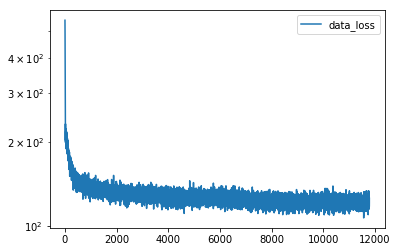

In [119]:
plot(losses_data,label='data_loss')
legend()
yscale('log')

In [0]:
res    = sess.run(z_samples, feed_dict={x: x_test[0:batch_size]})
labels = targets_test[0:batch_size]

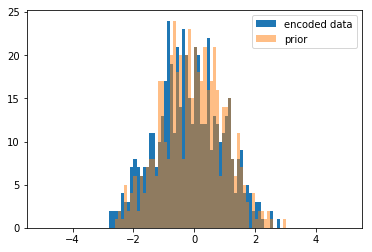

In [121]:
hist(res.flatten(),100,range=[-5,5],label='encoded data');
hist(randn(len(res.flatten())),100,range=[-5,5],alpha=0.5,label='prior');
legend()

<Figure size 360x360 with 0 Axes>

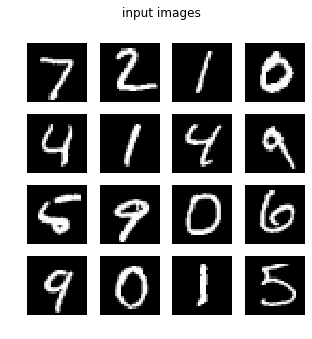

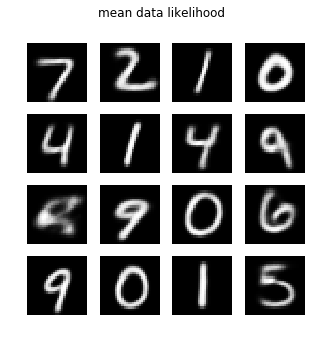

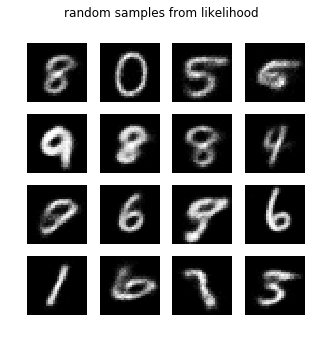

In [122]:
res, inim, s = sess.run([data_likelihood.mean(), x, x_sims], feed_dict={x: x_test[0:batch_size], sample_size: 100})
figure(figsize=(5,5))

    
figure(figsize=(5,5))
suptitle('input images')
for i in range(16):
    subplot(4,4,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(16):
    subplot(4,4,i+1)
    imshow((res )[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('random samples from likelihood')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(s[:,i,:].reshape((-1,28,28)),axis=0),cmap='gray',vmin=0); #colorbar()
    axis('off')

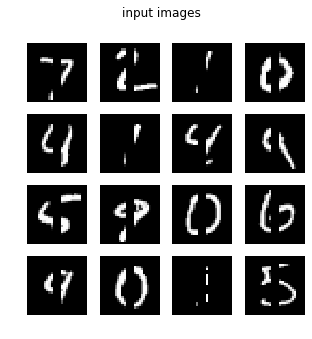

In [123]:
mask = np.ones(IMAGE_SHAPE, dtype=int)
mask[0:28,12:16]=0.
mask = mask.reshape((28*28))

masked_data = x_test[:batch_size2]*[mask]

figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size2,16)):
    if batch_size2<16:
      subplot(1,batch_size2,i+1)
      imshow(masked_data[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
    else:
      subplot(4,4,i+1)
      imshow(masked_data[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')

In [0]:
_ = sess.run(update1,feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})

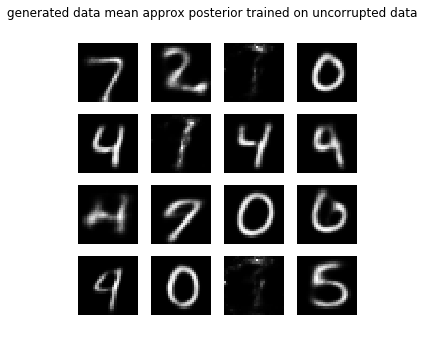

In [125]:
xrecons= sess.run(MAP_mean, feed_dict={x_corr: masked_data, x: masked_data, sample_size:100, mymask: mask})
xrecons.shape
    

figure(figsize=(5,5))
suptitle('generated data mean approx posterior trained on uncorrupted data')
for i in range(min(batch_size2,16)):
    if batch_size2<16:
      subplot(1,batch_size2,i+1)
      imshow(xrecons[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
    else:
      subplot(4,4,i+1)
      imshow(xrecons[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
      

In [0]:
posterior2_loss=[]

In [127]:
lrate=1e-2
for ii in range(20000):
  _, ll = sess.run([opt_op2,loss],feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})
  posterior2_loss.append(ll)
  if ii%100==0:
    print(ll)

102.49751
69.65076
68.8116
68.61265
68.55694
68.543144
68.53937
68.538605
68.53851
68.53851
68.53862
68.53841
68.538345
68.53848
68.53842
68.5385
68.53841
68.5385
68.53859
68.53856
68.53844
68.5385
68.53859
68.53848
68.538666
68.53841
68.53854
68.538605
68.5387
68.53867
68.53873
68.53873
68.53856
68.52365
68.51451
68.51442
68.51471
68.51451
68.514465
68.514725
68.51451
68.51471
68.51451
68.51455
68.51448
68.514786
68.514755
68.51459
68.51474
68.514656
68.51474
68.51465
68.51468
68.514565
68.51463
68.51459
68.51462
68.51469
68.51453
68.51462
68.51465
68.51462
68.51468
68.51465
68.51463
68.51451
68.514786
68.514595
68.51465
68.514694
68.51463
68.51465
68.51468
68.51454
68.51451
68.51466
68.51451
68.51459
68.514626
68.51458
68.51457
68.51448
68.514755
68.51445
68.5146
68.514595
68.51471
68.51462
68.51463
68.51476
68.51465
68.514435
68.514656
68.51452
68.51463


KeyboardInterrupt: ignored

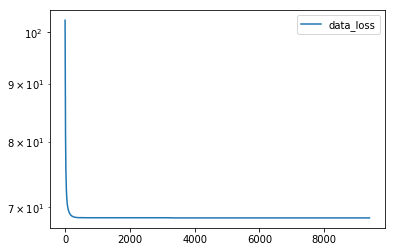

In [128]:
plot(posterior2_loss,label='data_loss')
legend()
yscale('log')

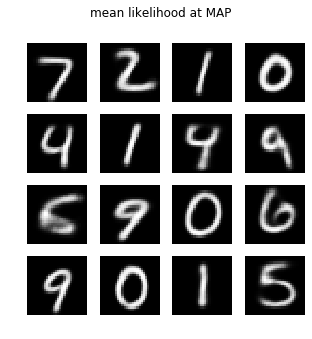

In [129]:
xrecons= sess.run(MAP_mean, feed_dict={x_corr: masked_data, x: masked_data, sample_size:100, mymask: mask})
xrecons.shape
    

figure(figsize=(5,5))
suptitle('mean likelihood at MAP')
for i in range(min(batch_size2,16)):
    if batch_size2<16:
      subplot(1,batch_size2,i+1)
      imshow(xrecons[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
    else:
      subplot(4,4,i+1)
      imshow(xrecons[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')

In [0]:
_=sess.run(update2,feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})

In [0]:
_=sess.run(update3,feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})

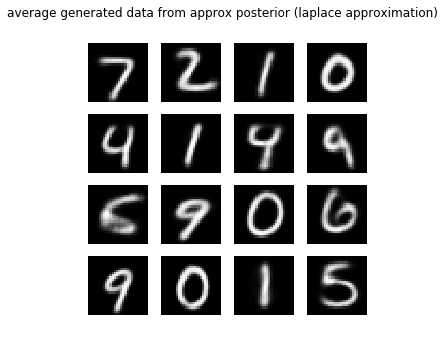

In [132]:
xrecons3 = sess.run(new_x_samples, feed_dict={x_corr: masked_data, x: masked_data, sample_size:40, mymask: mask})
    

figure(figsize=(5,5))
suptitle('average generated data from approx posterior (laplace approximation)')
for i in range(min(batch_size2,16)):
    if batch_size2<16:
      subplot(1,batch_size2,i+1)
      imshow(np.mean(xrecons3[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
    else:
      subplot(4,4,i+1)
      imshow(np.mean(xrecons3[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
      

In [0]:
posterior3_loss=[]

In [137]:
lrate=1e-4
for ii in range(2000):
  _, ll = sess.run([opt_op_elbo2, elbo2],feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})
  posterior3_loss.append(ll)
  if ii%100==0:
    print(ll)

74.69832
74.056564
73.89548
74.13494
73.94614
74.021835
73.939896
73.84134
73.90517
74.29848
73.66744
73.96087
73.999176
73.90905
74.12053
74.07516
73.94896
74.06316
73.84114
73.822655


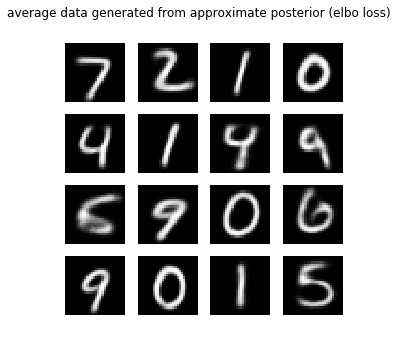

In [140]:
xrecons3= sess.run(x_samples_elbo, feed_dict={x_corr: masked_data, x: masked_data, sample_size:40, mymask: mask})
xrecons3.shape
    

figure(figsize=(5,5))
suptitle('average data generated from approximate posterior (elbo loss)')
for i in range(min(batch_size2,16)):
    if batch_size2<16:
      subplot(1,batch_size2,i+1)
      imshow(np.mean(xrecons3[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
    else:
      subplot(4,4,i+1)
      imshow(np.mean(xrecons3[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')